In [138]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt

I will write some code to address the well known Titanic disaster competition on Kaggle. I will start with my own naive solution which earned me 0.78708 in score. I will then look at some advice by Gunes Evitan (available [here](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410)) on how to improve this.

# Naive setup

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [4]:
# function to engineer features on datasets
def feature_engineering(df):
    df["is_woman"] = np.where(df["Sex"] == "female", True, False)
    df["has_cabin"] = -df["Cabin"].isna()
    df["is_child_or_old"] = np.where(
        (df["Age"] < df["Age"].quantile(0.1)) | (df["Age"] > df["Age"].quantile(0.9)),
        True,
        False,
    )
    df["embarked_s"] = np.where(df["Embarked"] == "S", True, False)
    df["embarked_c"] = np.where(df["Embarked"] == "C", True, False)
    df["embarked_q"] = np.where(df["Embarked"] == "Q", True, False)
    df["is_stowaway"] = np.where(df["Embarked"].isna(), True, False)
    df["cabin_level"] = df["Cabin"].apply(lambda x: ord(str(x)[0].lower()) - 96)
    df.loc[df["cabin_level"] > 10, "cabin_level"] = 0


feature_engineering(train_df)
feature_engineering(test_df)

In [10]:
# Features we consider
features = [
    "Pclass",
    "is_woman",
    "is_child_or_old",
    "SibSp",
    "Parch",
    "has_cabin",
    "embarked_s",
    "embarked_c",
    "embarked_q",
    # "is_stowaway",
    # "cabin_level",
]
# Target to predict
target = "Survived"

# Train and test dataframe
X_train = train_df[features]
X_test = test_df[features]

y_train = train_df[target]

Now we briefly compare various models: Logistic Regression, KNeighbors Classifier, SVC, Random Forest Classifier

In [11]:
Log_model = LogisticRegression()
scores_log = cross_val_score(Log_model, X_train, y_train, cv=5)
scores_log.mean()

0.7856443412215178

In [12]:
KNN_model = KNeighborsClassifier()
scores_knn = cross_val_score(KNN_model, X_train, y_train, cv=5)
scores_knn.mean()

0.7901261691042621

In [13]:
SVC_model = SVC()
scores_SVC = cross_val_score(SVC_model, X_train, y_train, cv=5)
scores_SVC.mean()

0.8103069487163392

In [14]:
RFC_model = RandomForestClassifier()
scores_RFC = cross_val_score(RFC_model, X_train, y_train, cv=5)
scores_RFC.mean()

0.8125792480070304

The RFC and SVC models are similar in results

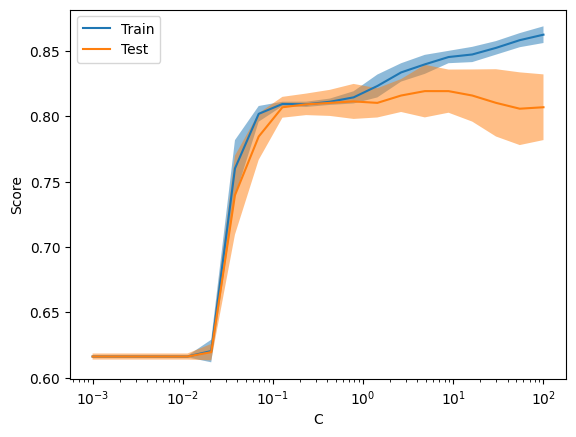

In [15]:
ValidationCurveDisplay.from_estimator(
    SVC(),
    X_train,
    y_train,
    param_name="C",
    param_range=np.logspace(-3, 2, 20),
)

In [16]:
model = SVC(C=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [17]:
output = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": predictions})
output.to_csv("titanic-disaster-submission.csv", index=False)

# Refined method

## Data cleanup

Now I will do the same but following advice on how to tweak this result

In [98]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# We concatenate the two dataframes
full_df = pd.concat([train_df, test_df], sort=True).reset_index(drop=True)

In [99]:
# Pclass is strongly correlated with Age, Fare and Survived
display(
    full_df[["Age", "Pclass", "SibSp", "Fare", "Parch", "Survived", "PassengerId"]]
    .corr()
    .abs()
)

,Age,Pclass,SibSp,Fare,Parch,Survived,PassengerId
Age,1.000000,0.408106,0.243699,0.178740,0.150917,0.077221,0.028814
Pclass,0.408106,1.000000,0.060832,0.558629,0.018322,0.338481,0.038354
SibSp,0.243699,0.060832,1.000000,0.160238,0.373587,0.035322,0.055224
Fare,0.178740,0.558629,0.160238,1.000000,0.221539,0.257307,0.031428
Parch,0.150917,0.018322,0.373587,0.221539,1.000000,0.081629,0.008942
Survived,0.077221,0.338481,0.035322,0.257307,0.081629,1.000000,0.005007
PassengerId,0.028814,0.038354,0.055224,0.031428,0.008942,0.005007,1.000000


In [100]:
# So we'll make groups of Pclass and use their age median to fill the missing values of Age
full_df_per_class = full_df.groupby(["Pclass", "Sex"])
median_age_per_class = full_df_per_class["Age"].median()
display(median_age_per_class)

# We then fill the missing ages
full_df["Age"] = (
    full_df_per_class["Age"].apply(lambda x: x.fillna(x.median())).reset_index()["Age"]
)

# From Google, Passengers 62 and 830 (see https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)
full_df.loc[full_df["PassengerId"] == 62, "Embarked"] = "S"
full_df.loc[full_df["PassengerId"] == 830, "Embarked"] = "S"

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

In [101]:
# We still need to fill the missing Fare value. The Fare is correlated to Parch, SibSp and Pclass so we groupby these
med_fare = full_df.groupby(["Pclass", "SibSp", "Parch"])["Fare"].median()
display(med_fare)

full_df.loc[full_df["Fare"].isna(), "Fare"] = full_df.loc[full_df["Fare"].isna()].apply(
    lambda x: med_fare[x["Pclass"], x["SibSp"], x["Parch"]], axis=1
)

Pclass  SibSp  Parch
1       0      0         31.33960
               1         63.35830
               2         83.15830
        1      0         75.25000
               1         83.15830
               2        120.00000
               3        262.37500
               4        263.00000
        2      0         51.47920
               2        262.37500
        3      2        263.00000
2       0      0         13.00000
               1         23.00000
               2         26.25000
               3         39.00000
        1      0         26.00000
               1         26.25000
               2         41.57920
               3         23.00000
        2      0         73.50000
               1         33.00000
               3         18.75000
        3      0         21.00000
3       0      0          7.85420
               1         12.47500
               2         15.24580
               3         19.25830
               4         23.27085
               5         34

In [102]:
# The cabin first letter gives the position in the boat.
# A, B, C for 1st class
# D, E for all classes
# F, G for 2nd, 3rd classes
# We will create the Deck feature, with 'M' for missing
full_df["Deck"] = full_df["Cabin"].apply(lambda x: x[0] if pd.notnull(x) else "M")

In [103]:
display(full_df[["Deck", "Pclass", "PassengerId"]].groupby(["Deck", "Pclass"]).count())
# Cabins A,B,C are dominated by 1st class passengers. We will group the lone first class T passenger into A deck
idx = full_df.loc[full_df["Deck"] == "T"].index
full_df.loc[idx, "Deck"] = "A"

# We then group A,B,C together, same for 'DE', same for 'FG'
full_df["Deck"] = full_df["Deck"].replace(["A", "B", "C"], "ABC")
full_df["Deck"] = full_df["Deck"].replace(["D", "E"], "DE")
full_df["Deck"] = full_df["Deck"].replace(["F", "G"], value="FG")

display(full_df["Deck"].value_counts())

# The M Deck has such a small survival rate we do not group it with others
full_df[["Deck", "Survived"]].groupby(["Deck"]).sum() / full_df[
    ["Deck", "Survived"]
].groupby(["Deck"]).count()

PassengerId
Deck Pclass             
A    1                22
B    1                65
C    1                94
D    1                40
     2                 6
E    1                34
     2                 4
     3                 3
F    2                13
     3                 8
G    3                 5
M    1                67
     2               254
     3               693
T    1                 1

Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

,Survived
Deck,
ABC,0.631148
DE,0.753846
FG,0.588235
M,0.299854


In [177]:
import string

In [178]:
def extract_surname(data):
    families = []

    for i in range(len(data)):
        name = data.iloc[i]

        if "(" in name:
            name_no_bracket = name.split("(")[0]
        else:
            name_no_bracket = name

        family = name_no_bracket.split(",")[0]
        title = name_no_bracket.split(",")[1].strip().split(" ")[0]

        for c in string.punctuation:
            family = family.replace(c, "").strip()

        families.append(family)

    return families


full_df["Family"] = extract_surname(full_df["Name"])

In [253]:
train_df_filled = full_df.loc[-full_df["Survived"].isna()]
test_df_filled = full_df.loc[full_df["Survived"].isna()].drop(["Survived"], axis=1)

## Distributions

In [211]:
def get_corr_df(df):
    df_corr = (
        df.drop(["PassengerId"], axis=1)
        .corr(numeric_only=True)
        .abs()
        .unstack()
        .sort_values(kind="quicksort", ascending=False)
        .reset_index()
    )
    df_corr.rename(
        columns={
            "level_0": "Feature 1",
            "level_1": "Feature 2",
            0: "Correlation Coefficient",
        },
        inplace=True,
    )
    df_corr.drop(df_corr.iloc[1::2].index, inplace=True)
    df_corr_nd = df_corr.drop(
        df_corr.loc[df_corr["Correlation Coefficient"] == 1.0].index
    )
    return df_corr_nd


train_df_corr = get_corr_df(train_df_filled)
test_df_corr = get_corr_df(test_df_filled)

In [212]:
display(train_df_corr.loc[train_df_corr["Correlation Coefficient"] > 0.1])
display(test_df_corr.loc[test_df_corr["Correlation Coefficient"] > 0.1])

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,SibSp,Parch,0.414838
10,Survived,Pclass,0.338481
12,Fare,Survived,0.257307
14,Fare,Parch,0.216225
16,Fare,SibSp,0.159651


,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577489
8,Parch,SibSp,0.306895
10,Fare,Parch,0.230410
12,SibSp,Fare,0.172032


<Axes: >

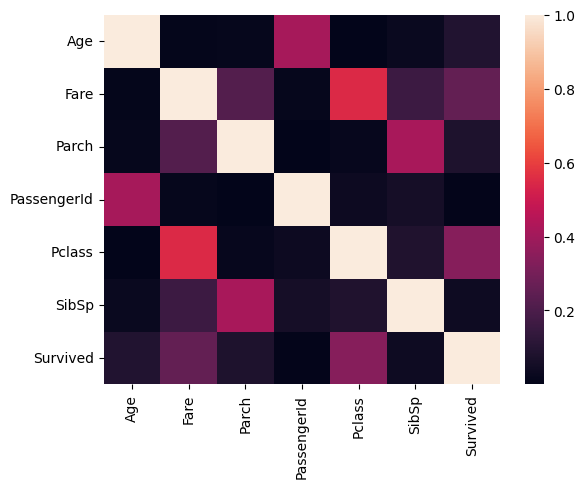

In [213]:
sns.heatmap(train_df_filled.corr(numeric_only=True).abs())

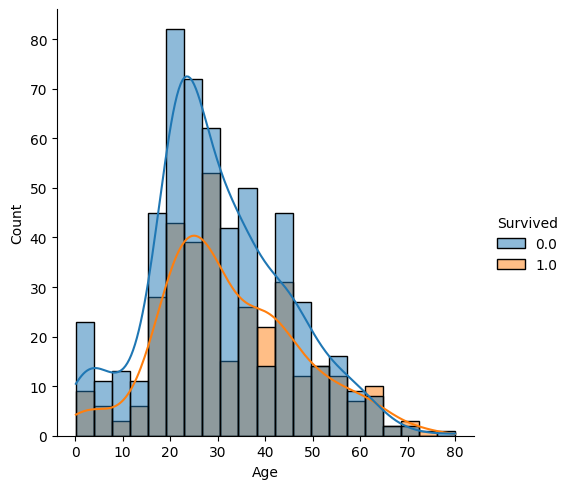

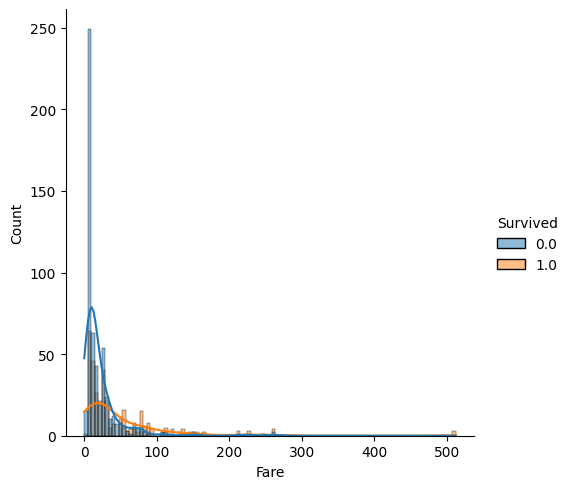

In [214]:
# Peaked distributions
sns.displot(train_df_filled, x="Age", hue="Survived", kde=True)

sns.displot(train_df_filled, x="Fare", hue="Survived", kde=True)

<Axes: xlabel='Pclass', ylabel='count'>

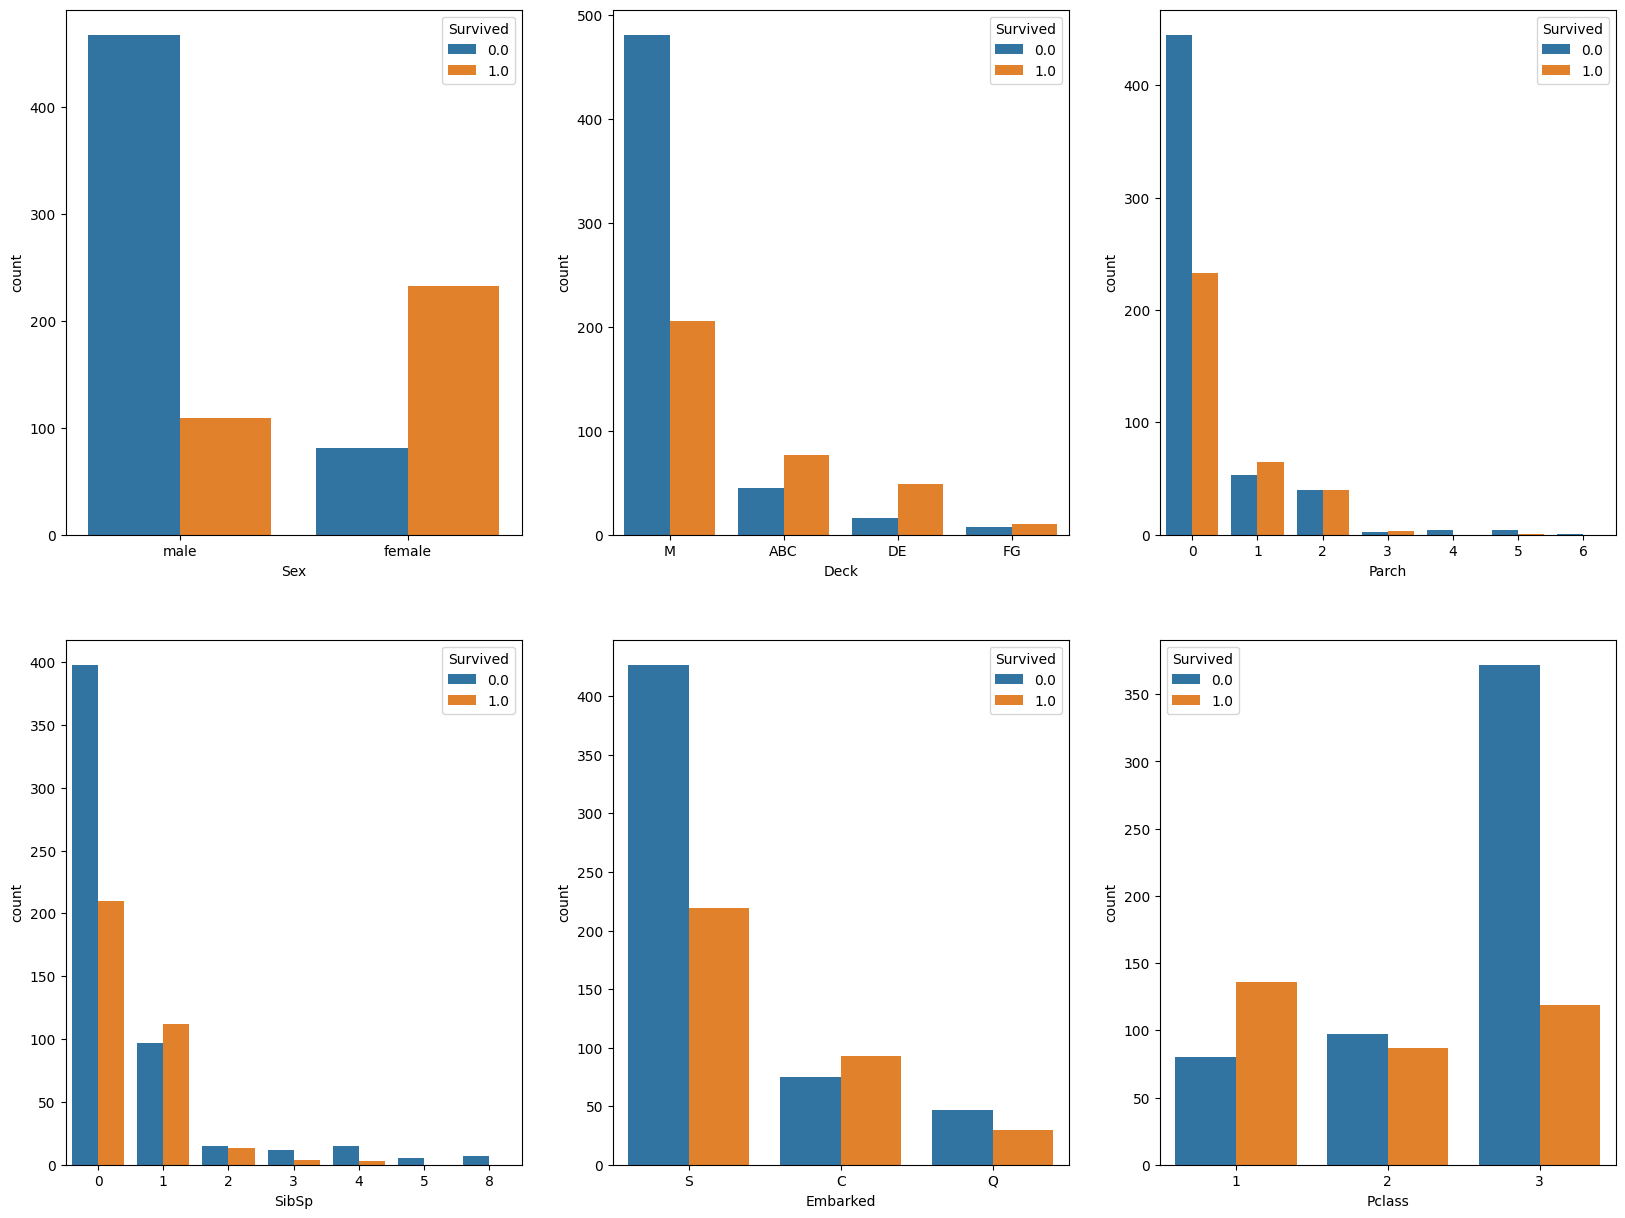

In [215]:
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
sns.countplot(train_df_filled, x="Sex", hue="Survived", ax=axs[0][0])
sns.countplot(train_df_filled, x="Deck", hue="Survived", ax=axs[0][1])
sns.countplot(train_df_filled, x="Parch", hue="Survived", ax=axs[0][2])
sns.countplot(train_df_filled, x="SibSp", hue="Survived", ax=axs[1][0])
sns.countplot(train_df_filled, x="Embarked", hue="Survived", ax=axs[1][1])
sns.countplot(train_df_filled, x="Pclass", hue="Survived", ax=axs[1][2])

Summary:

- Strong correlations between features
- Continuous features have spikes separating domains
- Categorical features have strong separation of mortality

## Feature engineering

In [254]:
# Low fare means high mortality. We discretize the continuous variable in quantiles. We choose 13 bins (a bit high but useful)
def fe_fare(df):
    df["Fare_bin"] = pd.qcut(df["Fare"], 13, duplicates="drop")


# Similarly, we discretize in 10 bins
def fe_age(df):
    df["Age_bin"] = pd.qcut(df["Age"], 10, duplicates="drop")


# Instead of SibSp and Parch, we make a family size variable
def fe_family(df):
    df["FamilySize"] = df["Parch"] + df["SibSp"] + 1
    family_map = {
        1: "Alone",
        2: "Small",
        3: "Small",
        4: "Small",
        5: "Medium",
        6: "Medium",
        7: "Large",
        8: "Large",
        11: "Large",
    }
    df["FamilySizeGrouped"] = df["FamilySize"].map(family_map)


# Ticket frequencies counts the size of groups, can have different meaning than family size
def fe_group(df):
    df["Ticket_Frequency"] = df.groupby("Ticket")["Ticket"].transform("count")


# From names, we can extract titles and marital status
def fe_title(df):
    df["Title"] = (
        df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    )
    df["Is_Married"] = 0
    df["Is_Married"].loc[df["Title"] == "Mrs"] = 1

    df["Title"] = df["Title"].replace(
        ["Miss", "Mrs", "Ms", "Mlle", "Lady", "Mme", "the Countess", "Dona"],
        "Miss/Mrs/Ms",
    )
    df["Title"] = df["Title"].replace(
        ["Dr", "Col", "Major", "Jonkheer", "Capt", "Sir", "Don", "Rev"],
        "Dr/Military/Noble/Clergy",
    )


def combined_fe(df):
    fe_fare(df)
    fe_age(df)
    fe_family(df)
    fe_group(df)
    fe_title(df)


combined_fe(train_df_filled)
combined_fe(test_df_filled)

/tmp/ipykernel_22192/263159214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fare_bin"] = pd.qcut(df["Fare"], 13, duplicates="drop")
/tmp/ipykernel_22192/263159214.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Age_bin"] = pd.qcut(df["Age"], 10, duplicates="drop")
/tmp/ipykernel_22192/263159214.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [255]:
display(
    train_df_filled.groupby(["Family"])[["Survived", "Family", "FamilySize"]].count()
)

,Survived,Family,FamilySize
Family,,,
Abbing,1,1,1
Abbott,2,2,2
Abelson,2,2,2
Adahl,1,1,1
Adams,1,1,1
...,...,...,...
de Mulder,1,1,1
de Pelsmaeker,1,1,1
del Carlo,1,1,1


In [256]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [
    x
    for x in train_df_filled["Family"].unique()
    if x in test_df_filled["Family"].unique()
]
non_unique_tickets = [
    x
    for x in train_df_filled["Ticket"].unique()
    if x in test_df_filled["Ticket"].unique()
]

df_family_survival_rate = train_df_filled.groupby("Family")[
    ["Survived", "FamilySize"]
].median()
df_ticket_survival_rate = train_df_filled.groupby("Ticket")[
    ["Survived", "Ticket_Frequency"]
].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if (
        df_family_survival_rate.index[i] in non_unique_families
        and df_family_survival_rate.iloc[i, 1] > 1
    ):
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[
            i, 0
        ]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if (
        df_ticket_survival_rate.index[i] in non_unique_tickets
        and df_ticket_survival_rate.iloc[i, 1] > 1
    ):
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[
            i, 0
        ]

In [257]:
mean_survival_rate = np.mean(train_df_filled["Survived"])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(train_df_filled)):
    if train_df_filled["Family"][i] in family_rates:
        train_family_survival_rate.append(family_rates[train_df_filled["Family"][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)

for i in range(len(test_df_filled)):
    if test_df_filled["Family"].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[test_df_filled["Family"].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)

train_df_filled["Family_Survival_Rate"] = train_family_survival_rate
train_df_filled["Family_Survival_Rate_NA"] = train_family_survival_rate_NA
test_df_filled["Family_Survival_Rate"] = test_family_survival_rate
test_df_filled["Family_Survival_Rate_NA"] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(train_df_filled)):
    if train_df_filled["Ticket"][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[train_df_filled["Ticket"][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)

for i in range(len(test_df_filled)):
    if test_df_filled["Ticket"].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[test_df_filled["Ticket"].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)

train_df_filled["Ticket_Survival_Rate"] = train_ticket_survival_rate
train_df_filled["Ticket_Survival_Rate_NA"] = train_ticket_survival_rate_NA
test_df_filled["Ticket_Survival_Rate"] = test_ticket_survival_rate
test_df_filled["Ticket_Survival_Rate_NA"] = test_ticket_survival_rate_NA

/tmp/ipykernel_22192/603502660.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filled["Family_Survival_Rate"] = train_family_survival_rate
/tmp/ipykernel_22192/603502660.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filled["Family_Survival_Rate_NA"] = train_family_survival_rate_NA
/tmp/ipykernel_22192/603502660.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [271]:
train_df_filled_2 = train_df_filled.drop(
    ["Cabin", "Name", "PassengerId", "Ticket", "Age", "Fare"], axis=1
)
test_df_filled_2 = test_df_filled.drop(
    ["Cabin", "Name", "PassengerId", "Ticket", "Age", "Fare"], axis=1
)

In [281]:
dfs = [train_df_filled_2.copy(), test_df_filled_2.copy()]
for df in dfs:
    df["Survival_Rate"] = (df["Ticket_Survival_Rate"] + df["Family_Survival_Rate"]) / 2
    df["Survival_Rate_NA"] = (
        df["Ticket_Survival_Rate_NA"] + df["Family_Survival_Rate_NA"]
    ) / 2

In [282]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

In [283]:
# Encode features as numerical labels
non_numeric_features = [
    "Embarked",
    "Sex",
    "Deck",
    "Title",
    "FamilySizeGrouped",
    "Age_bin",
    "Fare_bin",
]

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

# Encodes categorical features
cat_features = ["Pclass", "Sex", "Deck", "Embarked", "Title", "FamilySizeGrouped"]
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = (
            OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        )
        n = df[feature].nunique()
        cols = ["{}_{}".format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

dfs[0] = pd.concat([dfs[0], *encoded_features[:6]], axis=1)
dfs[1] = pd.concat([dfs[1], *encoded_features[6:]], axis=1)

In [284]:
drop_cols = [
    "Deck",
    "Embarked",
    "Family",
    "Family_Size",
    "Family_Size_Grouped",
    "Name",
    "Parch",
    "PassengerId",
    "Pclass",
    "Sex",
    "SibSp",
    "Ticket",
    "Title",
    "Ticket_Survival_Rate",
    "Family_Survival_Rate",
    "Ticket_Survival_Rate_NA",
    "Family_Survival_Rate_NA",
]

dfs[0].drop(columns=drop_cols, inplace=True, errors="ignore")
dfs[1].drop(columns=drop_cols, inplace=True, errors="ignore")

Now we briefly compare various models: Logistic Regression, KNeighbors Classifier, SVC, Random Forest Classifier

In [298]:
X_train = StandardScaler().fit_transform(dfs[0].drop(["Survived"], axis=1))
y_train = dfs[0]["Survived"]
X_test = StandardScaler().fit_transform(dfs[1])

In [299]:
Log_model = LogisticRegression()
scores_log = cross_val_score(Log_model, X_train, y_train, cv=5)
scores_log.mean()

0.8383780051471973

In [300]:
KNN_model = KNeighborsClassifier()
scores_knn = cross_val_score(KNN_model, X_train, y_train, cv=5)
scores_knn.mean()

0.8271797125102001

In [301]:
SVC_model = SVC()
scores_SVC = cross_val_score(SVC_model, X_train, y_train, cv=5)
scores_SVC.mean()

0.846218065407068

In [302]:
RFC_model = RandomForestClassifier()
scores_RFC = cross_val_score(RFC_model, X_train, y_train, cv=5)
scores_RFC.mean()

0.830500282468144

Let us keep with the SVC model

In [308]:
model = RandomForestClassifier(
    criterion="gini",
    n_estimators=1100,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=5,
    oob_score=True,
    n_jobs=-1,
    verbose=1,
)
model.fit(X_train, y_train)
predictions = model.predict(X_test).astype(int)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.3s finished


In [306]:
output = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": predictions})
output.to_csv("titanic-disaster-submission-fullfeatureengineering-RFC.csv", index=False)

## Unsupervised approach

In [83]:
from sklearn.decomposition import PCA
import seaborn as sns

In [84]:
pca = PCA(n_components=7)

In [87]:
X_train_pca = pca.fit_transform(X_train)
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df.columns = [f"PCA{n}" for n in range(1, 8)]

X_train_df_with_pca = pd.concat([X_train, X_train_pca_df, y_train])

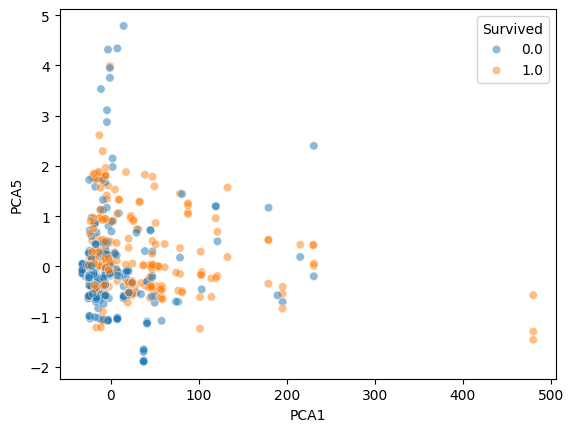

In [92]:
p1 = sns.scatterplot(X_train_df_with_pca, x="PCA1", y="PCA5", hue="Survived", alpha=0.5)
# p1.set_xlim((-30,30))

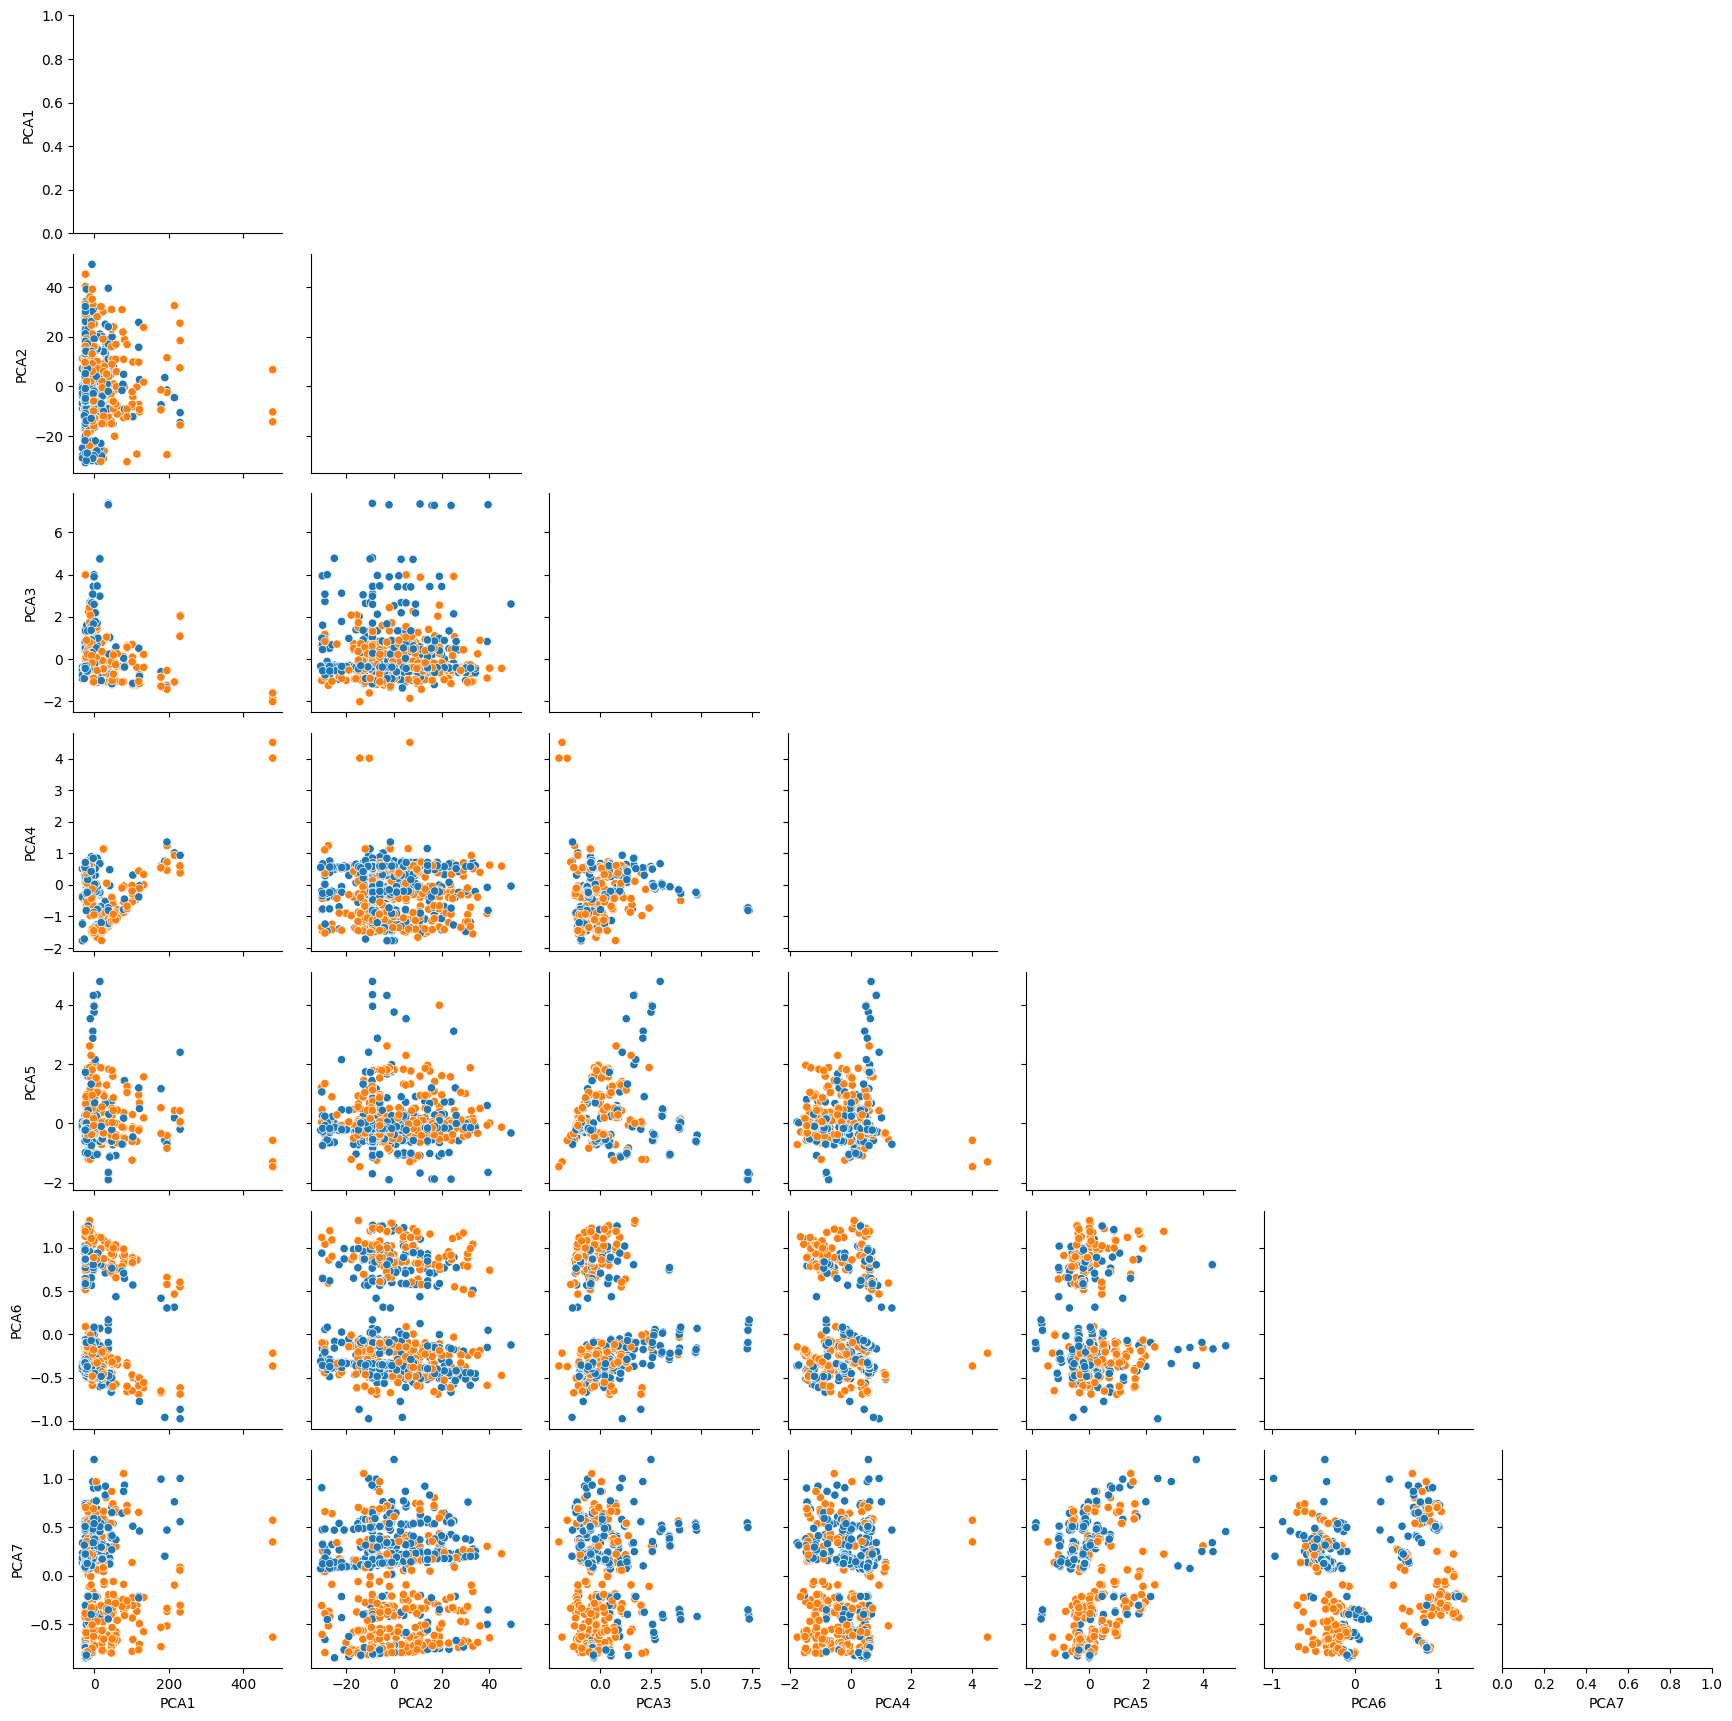

In [97]:
cols = list(X_train_pca_df.columns)
g = sns.PairGrid(
    X_train_df_with_pca, x_vars=cols, y_vars=cols, hue="Survived", corner=True
)
g.map_lower(sns.scatterplot)

The principal component analysis does not seem to separate between survivors and others